<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/IMDB_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autokeras
!pip install worldcloud

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import autokeras as ak

In [6]:
df = pd.read_csv('http://github.com/alankrantas/IMDB-movie-reviews-with-ratings_dataset/raw/main/imdb_sup.csv')
df

,Review,Rating,Sentiment
0,"Kurt Russell's chameleon-like performance, cou...",10,1
1,It was extremely low budget(it some scenes it ...,8,1
2,James Cagney is best known for his tough chara...,8,1
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8,1
4,One of the last classics of the French New Wav...,10,1
...,...,...,...
49995,(spoiler) it could be the one the worst movie ...,4,0
49996,"So, you've seen the Romero movies, yes? And yo...",1,0
49997,Just listen to the Broadway cast album and to ...,3,0
49998,I have been a fan of the Carpenters for a long...,3,0


# Preprocessing

In [7]:
x = df['Review'].to_numpy()
y = df['Sentiment'].to_numpy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

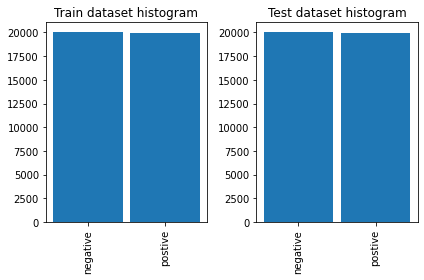

In [9]:
fig = plt.figure()
bin = np.arange(3)

labels = ('negative', 'postive', '') # x軸值(bin變數)需比分類數多1,才能達到置中效果,故需給多一個分類名稱(空字串),沒給可能error
ax = fig.add_subplot(1, 2, 1)
ax.set_xticks(bin)

# show the x-axis text and roatation 90 degree
ax.set_xticklabels(labels, rotation=90)
plt.hist(y_train, bins=bin-0.5, rwidth=0.9)
ax.set_title('Train dataset histogram')

ax = fig.add_subplot(1, 2, 2)
ax.set_xticks(bin)
ax.set_xticklabels(labels, rotation=90)
plt.hist(y_train, bins=bin-0.5, rwidth=0.9)
ax.set_title('Test dataset histogram')

plt.tight_layout()
plt.show()

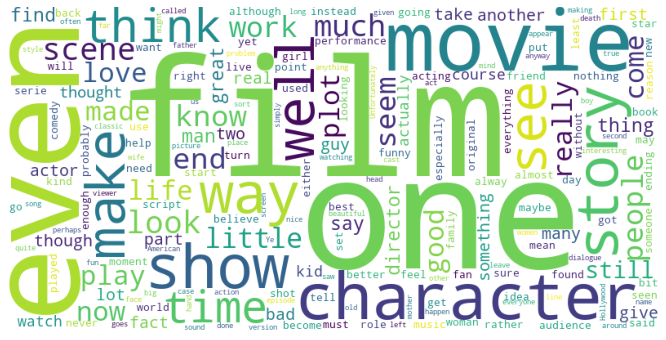

In [10]:
from wordcloud import WordCloud

# 將x_train所有字串連成單一字串,並將<br/>換行標籤換成空字串
text =''.join(x_train).replace('<br />', '')

# export a (size 800x400, 200words) WordCloud
ws = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# shows word cloud on matplotlib
plt.figure(figsize=(12,6))
plt.imshow(ws)
plt.axis('off')
plt.show()

In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3)]

# input node
input_node = ak.TextInput()

# output node (text to N-gram vector)
output_node = ak.TextToNgramVector(max_tokens=30000)(input_node)

# fully conected node
output_node = ak.DenseBlock()(output_node)

# classification node
output_node = ak.ClassificationHead()(output_node)

clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, max_trials = 3
)

clf.fit(x_train, y_train, callbacks=callbacks)

Trial 3 Complete [00h 02m 15s]
val_loss: 0.2522827088832855

Best val_loss So Far: 0.2522827088832855
Total elapsed time: 00h 07m 38s
INFO:tensorflow:Oracle triggered exit
1250/1250 [==============================] - 36s 28ms/step - loss: 0.3918 - accuracy: 0.8432
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


# Evaluate

In [12]:
clf.evaluate(x_test, y_test)

313/313 [==============================] - 5s 14ms/step - loss: 0.2535 - accuracy: 0.9018


[0.25352442264556885, 0.9017999768257141]

In [14]:
predicted = clf.predict(x_test[:10]).flatten().astype('uint8')

for i in range(10):
  print('Review:', x_test[i][:100], '...')
  print('Predict:', labels[predicted[i]])
  print('Real:', labels[y_test[i]])
  print('')


1/1 [==============================] - 0s 14ms/step
Review: Having read all of the comments on this film I am still amazed at Fox's reluctance to release a full ...
Predict: postive
Real: postive

Review: I like this film a lot. It has a wonderful chemistry between the actors and tells a story that is pr ...
Predict: postive
Real: postive

Review: I am a huge fan of Simon Pegg and have watched plenty of his movies until now and none of them have  ...
Predict: negative
Real: postive

Review: This was what black society was like before the crack epidemics, gangsta rap, and AIDS that beset th ...
Predict: postive
Real: postive

Review: pretty disappointing. i was expecting more of a horror/thriller -- but this seemed to be more of an  ...
Predict: negative
Real: negative

Review: As a flagship show, Attack of the Show (AOTS) is endemic of the larger fall of G4 TV; it is a show ( ...
Predict: negative
Real: negative

Review: Thomas Capano was not Anne Marie's boss Tom Carper, the Governor 

# Visualization

In [16]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLast  (None, 1)                0         
 Dim)                                                            
                                                                 
 text_vectorization (TextVec  (None, 30000)            1         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 32)                960032    
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0     

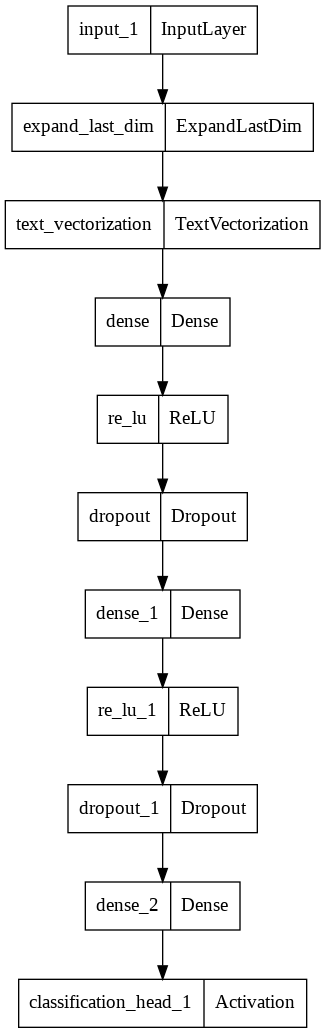

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model)